# Model Training & Evaluation

**Reference:** Paper 1 - OpenFPL (Groos, 2025)

**Models:**
1. Naive Baseline - Last 5 average (form_last_5)
2. Linear Regression (professor requirement) - Tier 1 features
3. XGBoost Regressor - Tier 2 features
4. Random Forest Regressor - Tier 2 features

**Evaluation:**
- RMSE and MAE by return category (Zeros, Blanks, Tickers, Haulers)
- RMSE and MAE by position (GK, DEF, MID, FWD)
- Comparison against Paper 1 benchmarks

In [36]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

from src.preprocessing import TIER1_FEATURES, TIER2_FEATURES

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print('Setup complete')

Setup complete


## 1. Load Data

In [37]:
data_dir = Path('../data/processed/tier2_2022-23_to_2023-24')

X_train = pd.read_csv(data_dir / 'X_train.csv')
X_test = pd.read_csv(data_dir / 'X_test.csv')
y_train = pd.read_csv(data_dir / 'y_train.csv')['total_points']
y_test = pd.read_csv(data_dir / 'y_test.csv')['total_points']

# Full DataFrames for position/category grouping
train_full = pd.read_csv(data_dir / 'train_full.csv')
test_full = pd.read_csv(data_dir / 'test_full.csv')

print(f'Train: {X_train.shape[0]:,} samples, {X_train.shape[1]} features')
print(f'Test:  {X_test.shape[0]:,} samples, {X_test.shape[1]} features')
print(f'\nTarget - Train: mean={y_train.mean():.2f}, std={y_train.std():.2f}')
print(f'Target - Test:  mean={y_test.mean():.2f}, std={y_test.std():.2f}')

Train: 22,002 samples, 29 features
Test:  25,384 samples, 29 features

Target - Train: mean=1.26, std=2.49
Target - Test:  mean=1.08, std=2.38


## 2. Helper Functions

In [38]:
def get_category(pts):
    """Paper 1 return categories."""
    if pts == 0:
        return 'Zeros'
    elif pts <= 2:
        return 'Blanks'
    elif pts <= 4:
        return 'Tickers'
    else:
        return 'Haulers'


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def evaluate_model(y_true, y_pred, positions, name='Model'):
    """Full evaluation: overall, by category, by position."""
    results = {'model': name}
    
    # Overall
    results['overall_rmse'] = rmse(y_true, y_pred)
    results['overall_mae'] = mean_absolute_error(y_true, y_pred)
    
    # By return category
    categories = pd.Series([get_category(p) for p in y_true], index=y_true.index)
    for cat in ['Zeros', 'Blanks', 'Tickers', 'Haulers']:
        mask = categories == cat
        if mask.sum() > 0:
            results[f'{cat}_rmse'] = rmse(y_true[mask], y_pred[mask])
            results[f'{cat}_mae'] = mean_absolute_error(y_true[mask], y_pred[mask])
            results[f'{cat}_n'] = int(mask.sum())
    
    # By position
    for pos in ['GK', 'DEF', 'MID', 'FWD']:
        mask = positions == pos
        if mask.sum() > 0:
            results[f'{pos}_rmse'] = rmse(y_true[mask], y_pred[mask])
            results[f'{pos}_mae'] = mean_absolute_error(y_true[mask], y_pred[mask])
            results[f'{pos}_n'] = int(mask.sum())
    
    return results


def print_results(res):
    """Pretty-print evaluation results."""
    print(f"\n{'='*60}")
    print(f"  {res['model']}")
    print(f"{'='*60}")
    print(f"  Overall:  RMSE={res['overall_rmse']:.4f}  MAE={res['overall_mae']:.4f}")
    print(f"\n  By Category:       RMSE     MAE       N")
    for cat in ['Zeros', 'Blanks', 'Tickers', 'Haulers']:
        print(f"    {cat:10s}  {res[f'{cat}_rmse']:8.4f}  {res[f'{cat}_mae']:7.4f}  {res[f'{cat}_n']:6,}")
    print(f"\n  By Position:       RMSE     MAE       N")
    for pos in ['GK', 'DEF', 'MID', 'FWD']:
        print(f"    {pos:10s}  {res[f'{pos}_rmse']:8.4f}  {res[f'{pos}_mae']:7.4f}  {res[f'{pos}_n']:6,}")


# Build position series aligned with X_test index
test_positions = test_full['position_label'].values
test_categories = pd.Series([get_category(p) for p in y_test], index=y_test.index)

print(f'Category distribution in test set:')
print(test_categories.value_counts().sort_index())
print(f'\nPosition distribution in test set:')
print(pd.Series(test_positions).value_counts().sort_index())

Category distribution in test set:
Blanks      6080
Haulers     2088
Tickers      835
Zeros      16381
Name: count, dtype: int64

Position distribution in test set:
DEF     8200
FWD     3296
GK      2903
MID    10985
Name: count, dtype: int64


## 3. Train Models

### 3.1 Naive Baseline (Last 5 Average)

In [39]:
# Naive baseline: predict points = form_last_5 (average of last 5 GWs)
naive_preds = X_test['form_last_5'].values

naive_results = evaluate_model(
    y_test, naive_preds, pd.Series(test_positions, index=y_test.index),
    name='Naive Baseline (Last 5 Avg)'
)
print_results(naive_results)


  Naive Baseline (Last 5 Avg)
  Overall:  RMSE=2.1179  MAE=1.0145

  By Category:       RMSE     MAE       N
    Zeros         0.9761   0.3548  16,381
    Blanks        1.8274   1.3180   6,080
    Tickers       2.0349   1.6903     835
    Haulers       5.9729   5.0359   2,088

  By Position:       RMSE     MAE       N
    GK            1.5920   0.6445   2,903
    DEF           2.1625   1.0884   8,200
    MID           2.1444   1.0341  10,985
    FWD           2.3136   1.0912   3,296


### 3.2 Linear Regression (Tier 1 Features)

In [40]:
# Linear Regression needs scaling
tier1_cols = [f for f in TIER1_FEATURES if f in X_train.columns]

scaler = StandardScaler()
X_train_t1_scaled = scaler.fit_transform(X_train[tier1_cols])
X_test_t1_scaled = scaler.transform(X_test[tier1_cols])

lr_model = LinearRegression()
lr_model.fit(X_train_t1_scaled, y_train)
lr_preds = lr_model.predict(X_test_t1_scaled)

lr_results = evaluate_model(
    y_test, lr_preds, pd.Series(test_positions, index=y_test.index),
    name=f'Linear Regression (Tier 1, {len(tier1_cols)} features)'
)
print_results(lr_results)

# Show coefficients
print(f'\n  Coefficients:')
for feat, coef in sorted(zip(tier1_cols, lr_model.coef_), key=lambda x: abs(x[1]), reverse=True):
    print(f'    {feat:25s} {coef:+.4f}')
print(f'    {"intercept":25s} {lr_model.intercept_:+.4f}')


  Linear Regression (Tier 1, 10 features)
  Overall:  RMSE=2.0022  MAE=1.0500

  By Category:       RMSE     MAE       N
    Zeros         0.8794   0.5051  16,381
    Blanks        1.4012   1.0989   6,080
    Tickers       1.5338   1.1808     835
    Haulers       6.0010   5.1300   2,088

  By Position:       RMSE     MAE       N
    GK            1.4893   0.7560   2,903
    DEF           2.0375   1.1145   8,200
    MID           2.0293   1.0584  10,985
    FWD           2.2062   1.1204   3,296

  Coefficients:
    minutes_last_3            +0.7773
    price                     +0.3155
    form_last_5               +0.2620
    ict_index_last_3          +0.2170
    pos_MID                   -0.0952
    opponent_difficulty       -0.0844
    was_home                  +0.0806
    pos_FWD                   -0.0758
    pos_DEF                   -0.0703
    form_last_3               +0.0022
    intercept                 +1.2558


### 3.3 XGBoost (Tier 2 Features)

In [41]:
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

xgb_results = evaluate_model(
    y_test, xgb_preds, pd.Series(test_positions, index=y_test.index),
    name=f'XGBoost (Tier 2, {len(X_train.columns)} features)'
)
print_results(xgb_results)


  XGBoost (Tier 2, 29 features)
  Overall:  RMSE=2.0189  MAE=1.0249

  By Category:       RMSE     MAE       N
    Zeros         0.9674   0.4618  16,381
    Blanks        1.5853   1.1771   6,080
    Tickers       1.5981   1.2936     835
    Haulers       5.8197   4.8924   2,088

  By Position:       RMSE     MAE       N
    GK            1.5487   0.7161   2,903
    DEF           2.0382   1.0994   8,200
    MID           2.0493   1.0223  10,985
    FWD           2.2239   1.1204   3,296


### 3.4 Random Forest (Tier 2 Features)

In [42]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rf_results = evaluate_model(
    y_test, rf_preds, pd.Series(test_positions, index=y_test.index),
    name=f'Random Forest (Tier 2, {len(X_train.columns)} features)'
)
print_results(rf_results)


  Random Forest (Tier 2, 29 features)
  Overall:  RMSE=1.9874  MAE=1.0211

  By Category:       RMSE     MAE       N
    Zeros         0.9532   0.4710  16,381
    Blanks        1.4817   1.1523   6,080
    Tickers       1.4166   1.1230     835
    Haulers       5.8048   4.9138   2,088

  By Position:       RMSE     MAE       N
    GK            1.4916   0.6852   2,903
    DEF           2.0357   1.1262   8,200
    MID           2.0088   1.0105  10,985
    FWD           2.1682   1.0907   3,296


## 4. Comparison Tables

### 4.1 Overall Comparison

In [43]:
all_results = [naive_results, lr_results, xgb_results, rf_results]

# Overall comparison table
overall_df = pd.DataFrame([{
    'Model': r['model'],
    'RMSE': r['overall_rmse'],
    'MAE': r['overall_mae'],
} for r in all_results]).set_index('Model')

print('OVERALL RESULTS')
print('=' * 60)
print(overall_df.to_string())
print(f'\nTarget: MAE < 2.0')

OVERALL RESULTS
                                             RMSE       MAE
Model                                                      
Naive Baseline (Last 5 Avg)              2.117887  1.014484
Linear Regression (Tier 1, 10 features)  2.002229  1.049968
XGBoost (Tier 2, 29 features)            2.018864  1.024938
Random Forest (Tier 2, 29 features)      1.987418  1.021080

Target: MAE < 2.0


### 4.2 By Return Category (Paper 1 Comparison)

In [44]:
# Paper 1 benchmarks (RMSE / MAE at 1 GW ahead)
paper1_benchmarks = {
    'Zeros':   {'Last5_rmse': 0.791, 'Last5_mae': 0.270, 'OpenFPL_rmse': 0.818, 'OpenFPL_mae': 0.427},
    'Blanks':  {'Last5_rmse': 1.400, 'Last5_mae': 0.652, 'OpenFPL_rmse': 1.291, 'OpenFPL_mae': 0.749},
    'Tickers': {'Last5_rmse': 2.136, 'Last5_mae': 1.645, 'OpenFPL_rmse': 1.517, 'OpenFPL_mae': 1.127},
    'Haulers': {'Last5_rmse': 5.613, 'Last5_mae': 4.709, 'OpenFPL_rmse': 5.142, 'OpenFPL_mae': 4.317},
}

print('RMSE BY RETURN CATEGORY')
print('=' * 90)
header = f'{"Category":10s} | {"Paper1 Last5":>12s} | {"Paper1 OpenFPL":>14s} | '
header += ' | '.join([f'{r["model"][:15]:>15s}' for r in all_results])
print(header)
print('-' * 90)

for cat in ['Zeros', 'Blanks', 'Tickers', 'Haulers']:
    p1 = paper1_benchmarks[cat]
    row = f'{cat:10s} | {p1["Last5_rmse"]:12.3f} | {p1["OpenFPL_rmse"]:14.3f} | '
    row += ' | '.join([f'{r[f"{cat}_rmse"]:15.3f}' for r in all_results])
    print(row)

print(f'\n\nMAE BY RETURN CATEGORY')
print('=' * 90)
header = f'{"Category":10s} | {"Paper1 Last5":>12s} | {"Paper1 OpenFPL":>14s} | '
header += ' | '.join([f'{r["model"][:15]:>15s}' for r in all_results])
print(header)
print('-' * 90)

for cat in ['Zeros', 'Blanks', 'Tickers', 'Haulers']:
    p1 = paper1_benchmarks[cat]
    row = f'{cat:10s} | {p1["Last5_mae"]:12.3f} | {p1["OpenFPL_mae"]:14.3f} | '
    row += ' | '.join([f'{r[f"{cat}_mae"]:15.3f}' for r in all_results])
    print(row)

RMSE BY RETURN CATEGORY
Category   | Paper1 Last5 | Paper1 OpenFPL | Naive Baseline  | Linear Regressi | XGBoost (Tier 2 | Random Forest (
------------------------------------------------------------------------------------------
Zeros      |        0.791 |          0.818 |           0.976 |           0.879 |           0.967 |           0.953
Blanks     |        1.400 |          1.291 |           1.827 |           1.401 |           1.585 |           1.482
Tickers    |        2.136 |          1.517 |           2.035 |           1.534 |           1.598 |           1.417
Haulers    |        5.613 |          5.142 |           5.973 |           6.001 |           5.820 |           5.805


MAE BY RETURN CATEGORY
Category   | Paper1 Last5 | Paper1 OpenFPL | Naive Baseline  | Linear Regressi | XGBoost (Tier 2 | Random Forest (
------------------------------------------------------------------------------------------
Zeros      |        0.270 |          0.427 |           0.355 |           0.505 

### 4.3 By Position (Paper 1 Comparison)

In [45]:
# Paper 1 position benchmarks (RMSE at 1 GW ahead)
paper1_pos = {
    'GK':  {'Last5_rmse': 0.672, 'OpenFPL_rmse': 0.616},
    'DEF': {'Last5_rmse': 0.753, 'OpenFPL_rmse': 0.812},
    'MID': {'Last5_rmse': 0.831, 'OpenFPL_rmse': 0.902},
    'FWD': {'Last5_rmse': 0.877, 'OpenFPL_rmse': 0.719},
}

print('RMSE BY POSITION')
print('=' * 90)
header = f'{"Position":10s} | {"Paper1 Last5":>12s} | {"Paper1 OpenFPL":>14s} | '
header += ' | '.join([f'{r["model"][:15]:>15s}' for r in all_results])
print(header)
print('-' * 90)

for pos in ['GK', 'DEF', 'MID', 'FWD']:
    p1 = paper1_pos[pos]
    row = f'{pos:10s} | {p1["Last5_rmse"]:12.3f} | {p1["OpenFPL_rmse"]:14.3f} | '
    row += ' | '.join([f'{r[f"{pos}_rmse"]:15.3f}' for r in all_results])
    print(row)

print(f'\n\nMAE BY POSITION')
print('=' * 90)
header = f'{"Position":10s} | '
header += ' | '.join([f'{r["model"][:15]:>15s}' for r in all_results])
print(header)
print('-' * 90)

for pos in ['GK', 'DEF', 'MID', 'FWD']:
    row = f'{pos:10s} | '
    row += ' | '.join([f'{r[f"{pos}_mae"]:15.3f}' for r in all_results])
    print(row)

RMSE BY POSITION
Position   | Paper1 Last5 | Paper1 OpenFPL | Naive Baseline  | Linear Regressi | XGBoost (Tier 2 | Random Forest (
------------------------------------------------------------------------------------------
GK         |        0.672 |          0.616 |           1.592 |           1.489 |           1.549 |           1.492
DEF        |        0.753 |          0.812 |           2.162 |           2.038 |           2.038 |           2.036
MID        |        0.831 |          0.902 |           2.144 |           2.029 |           2.049 |           2.009
FWD        |        0.877 |          0.719 |           2.314 |           2.206 |           2.224 |           2.168


MAE BY POSITION
Position   | Naive Baseline  | Linear Regressi | XGBoost (Tier 2 | Random Forest (
------------------------------------------------------------------------------------------
GK         |           0.645 |           0.756 |           0.716 |           0.685
DEF        |           1.088 |           1

## 5. Visualizations

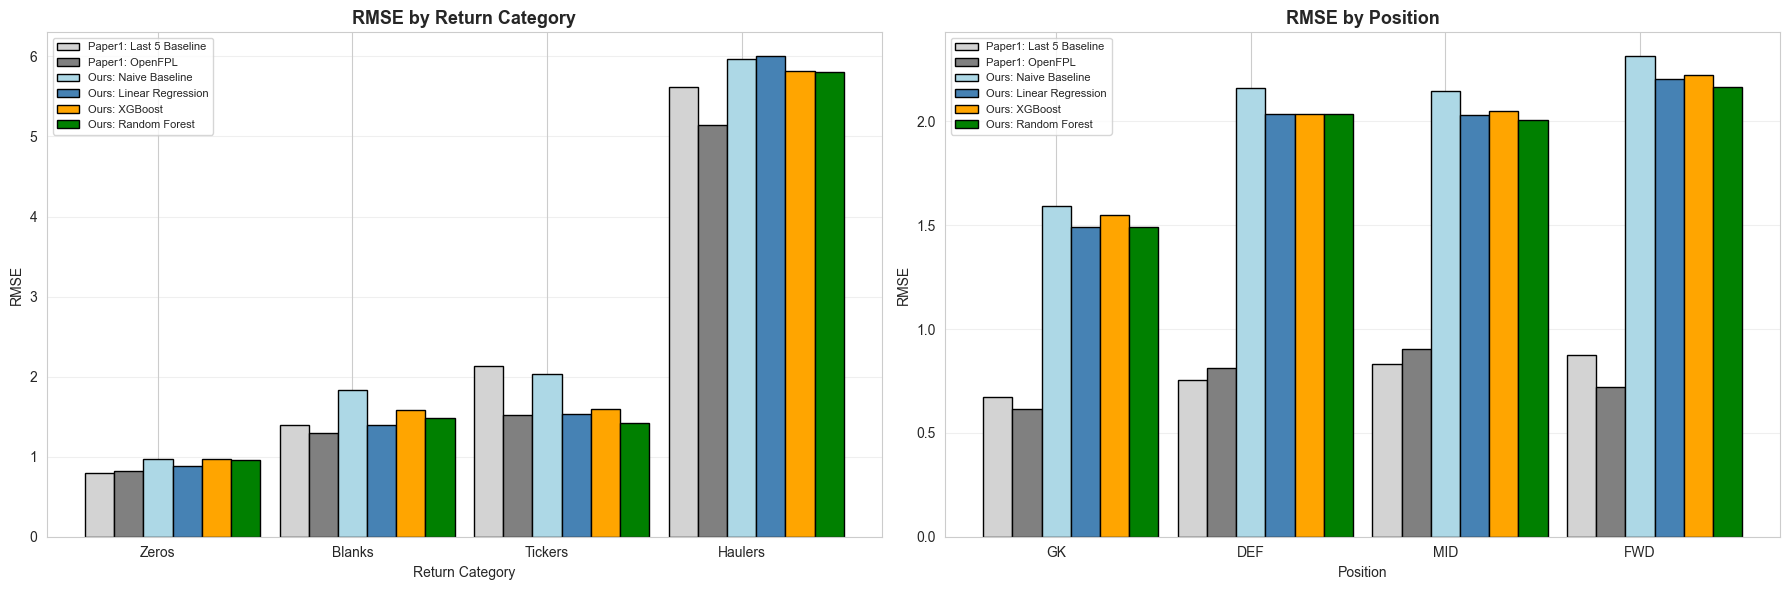

In [46]:
# Bar chart: RMSE by category for all models + Paper 1
categories = ['Zeros', 'Blanks', 'Tickers', 'Haulers']
x = np.arange(len(categories))
width = 0.15

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# RMSE by category
ax = axes[0]
ax.bar(x - 2*width, [paper1_benchmarks[c]['Last5_rmse'] for c in categories],
       width, label='Paper1: Last 5 Baseline', color='lightgray', edgecolor='black')
ax.bar(x - width, [paper1_benchmarks[c]['OpenFPL_rmse'] for c in categories],
       width, label='Paper1: OpenFPL', color='gray', edgecolor='black')
ax.bar(x, [naive_results[f'{c}_rmse'] for c in categories],
       width, label='Ours: Naive Baseline', color='lightblue', edgecolor='black')
ax.bar(x + width, [lr_results[f'{c}_rmse'] for c in categories],
       width, label='Ours: Linear Regression', color='steelblue', edgecolor='black')
ax.bar(x + 2*width, [xgb_results[f'{c}_rmse'] for c in categories],
       width, label='Ours: XGBoost', color='orange', edgecolor='black')
ax.bar(x + 3*width, [rf_results[f'{c}_rmse'] for c in categories],
       width, label='Ours: Random Forest', color='green', edgecolor='black')

ax.set_xlabel('Return Category')
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Return Category', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(fontsize=8)
ax.grid(axis='y', alpha=0.3)

# RMSE by position
positions = ['GK', 'DEF', 'MID', 'FWD']
x2 = np.arange(len(positions))

ax = axes[1]
ax.bar(x2 - 2*width, [paper1_pos[p]['Last5_rmse'] for p in positions],
       width, label='Paper1: Last 5 Baseline', color='lightgray', edgecolor='black')
ax.bar(x2 - width, [paper1_pos[p]['OpenFPL_rmse'] for p in positions],
       width, label='Paper1: OpenFPL', color='gray', edgecolor='black')
ax.bar(x2, [naive_results[f'{p}_rmse'] for p in positions],
       width, label='Ours: Naive Baseline', color='lightblue', edgecolor='black')
ax.bar(x2 + width, [lr_results[f'{p}_rmse'] for p in positions],
       width, label='Ours: Linear Regression', color='steelblue', edgecolor='black')
ax.bar(x2 + 2*width, [xgb_results[f'{p}_rmse'] for p in positions],
       width, label='Ours: XGBoost', color='orange', edgecolor='black')
ax.bar(x2 + 3*width, [rf_results[f'{p}_rmse'] for p in positions],
       width, label='Ours: Random Forest', color='green', edgecolor='black')

ax.set_xlabel('Position')
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Position', fontweight='bold', fontsize=13)
ax.set_xticks(x2)
ax.set_xticklabels(positions)
ax.legend(fontsize=8)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

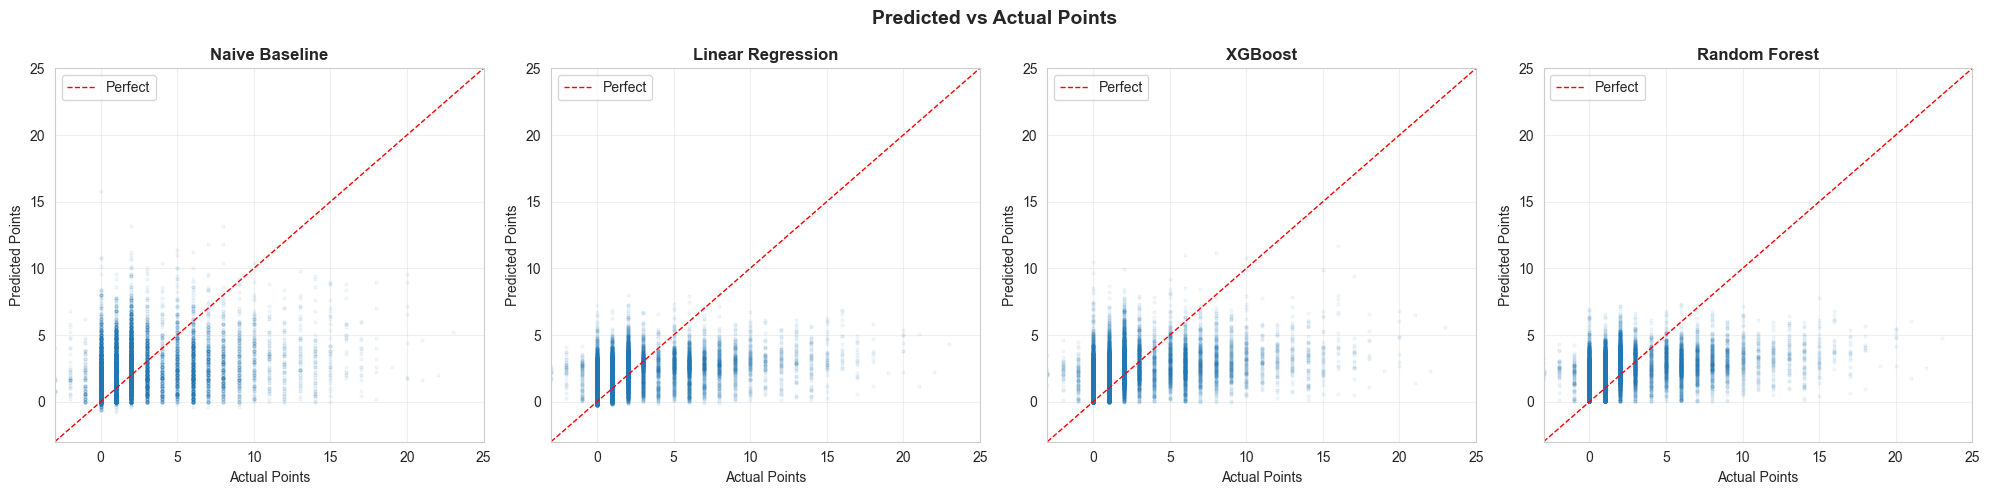

In [47]:
# Prediction vs Actual scatter plots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

models = [
    ('Naive Baseline', naive_preds),
    ('Linear Regression', lr_preds),
    ('XGBoost', xgb_preds),
    ('Random Forest', rf_preds),
]

for ax, (name, preds) in zip(axes, models):
    ax.scatter(y_test, preds, alpha=0.05, s=5)
    ax.plot([-3, 25], [-3, 25], 'r--', lw=1, label='Perfect')
    ax.set_xlabel('Actual Points')
    ax.set_ylabel('Predicted Points')
    ax.set_title(name, fontweight='bold')
    ax.set_xlim(-3, 25)
    ax.set_ylim(-3, 25)
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Predicted vs Actual Points', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Feature Importance

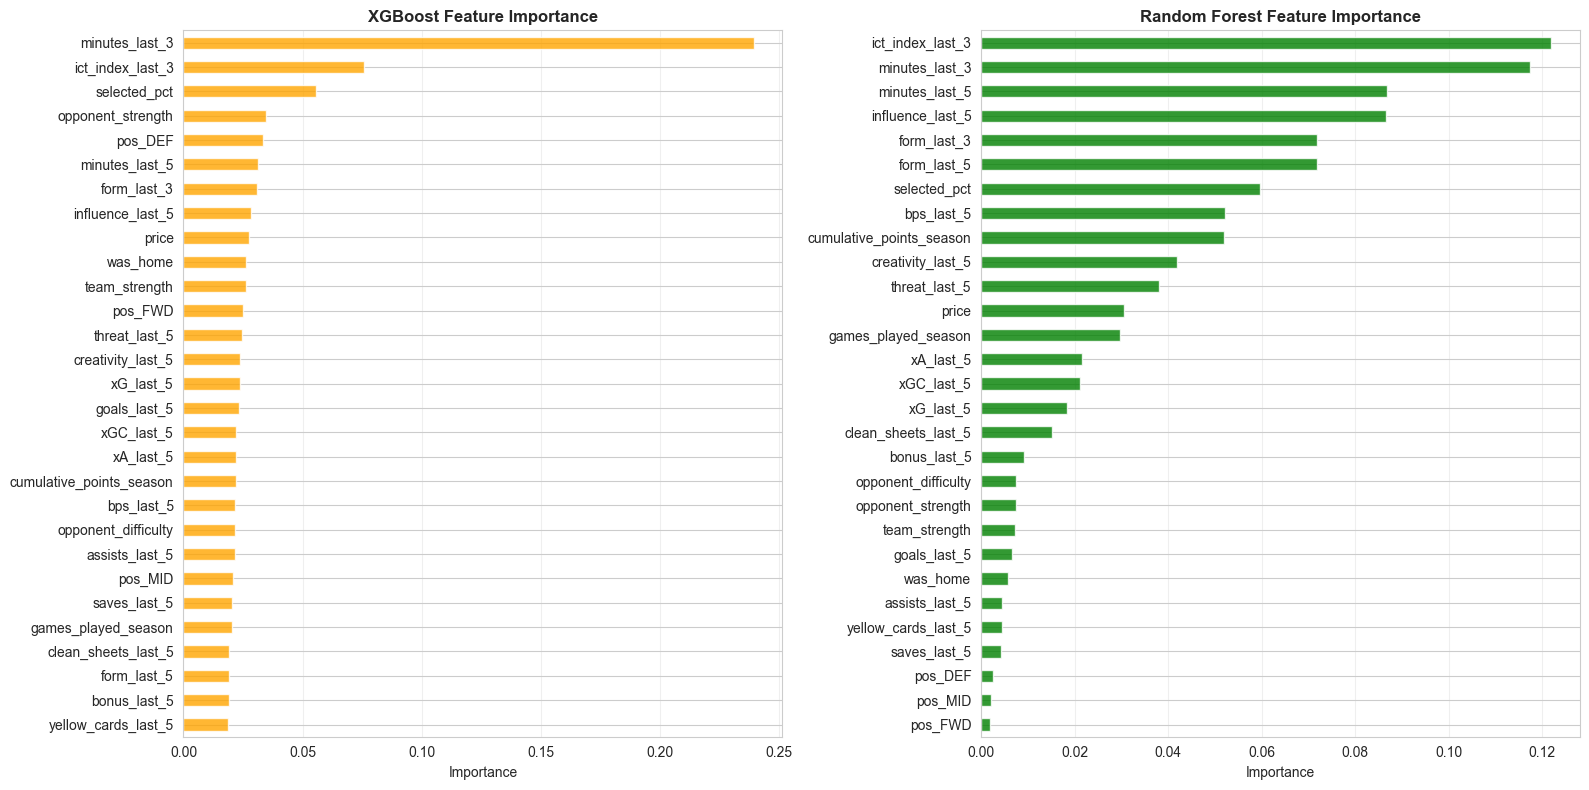

Top 10 features:
XGBoost                        | Random Forest                 
--------------------------------------------------------------
minutes_last_3            0.2394 | ict_index_last_3          0.1220
ict_index_last_3          0.0760 | minutes_last_3            0.1175
selected_pct              0.0555 | minutes_last_5            0.0868
opponent_strength         0.0348 | influence_last_5          0.0865
pos_DEF                   0.0335 | form_last_3               0.0719
minutes_last_5            0.0312 | form_last_5               0.0717
form_last_3               0.0310 | selected_pct              0.0597
influence_last_5          0.0282 | bps_last_5                0.0522
price                     0.0274 | cumulative_points_season  0.0520
was_home                  0.0264 | creativity_last_5         0.0418


In [48]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# XGBoost feature importance
xgb_imp = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values()
xgb_imp.plot(kind='barh', ax=axes[0], color='orange', alpha=0.8)
axes[0].set_title('XGBoost Feature Importance', fontweight='bold')
axes[0].set_xlabel('Importance')
axes[0].grid(axis='x', alpha=0.3)

# Random Forest feature importance
rf_imp = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values()
rf_imp.plot(kind='barh', ax=axes[1], color='green', alpha=0.8)
axes[1].set_title('Random Forest Feature Importance', fontweight='bold')
axes[1].set_xlabel('Importance')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print top 10 features for each
print('Top 10 features:')
print(f'{"XGBoost":30s} | {"Random Forest":30s}')
print('-' * 62)
xgb_top = xgb_imp.sort_values(ascending=False).head(10)
rf_top = rf_imp.sort_values(ascending=False).head(10)
for (xf, xv), (rf_f, rv) in zip(xgb_top.items(), rf_top.items()):
    print(f'{xf:25s} {xv:.4f} | {rf_f:25s} {rv:.4f}')

## 7. Error Analysis

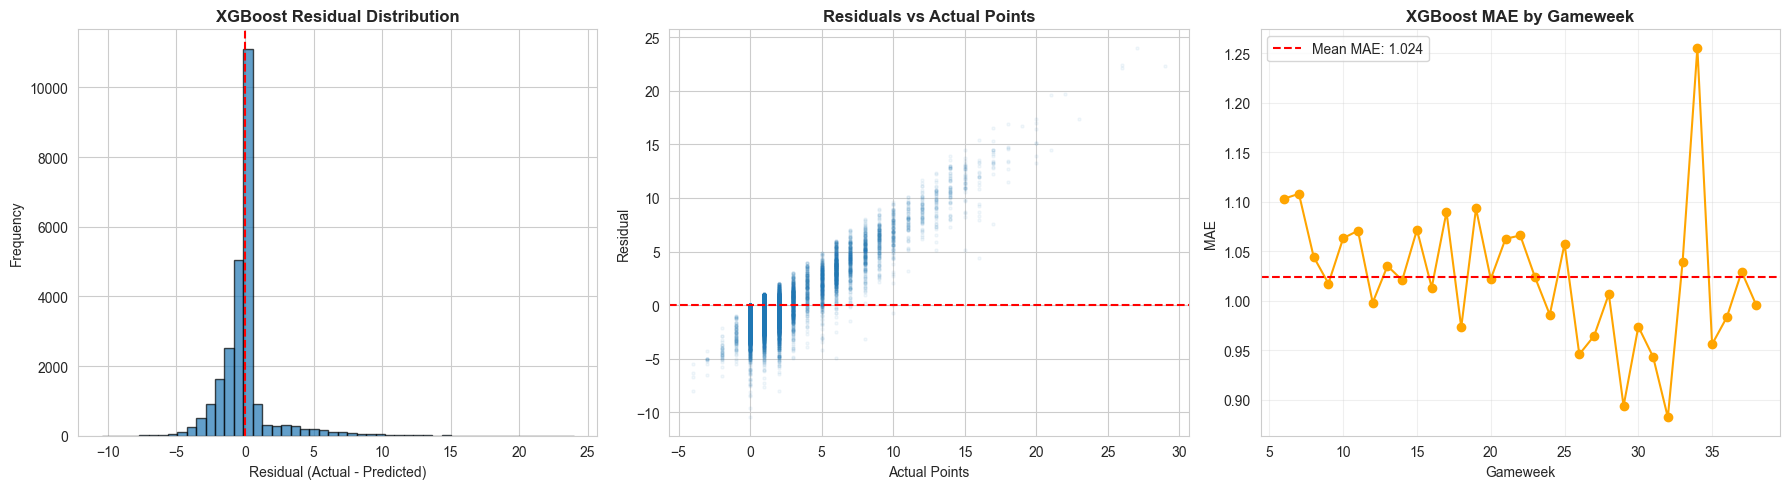

In [49]:
# Residual analysis for XGBoost (best tree model)
residuals = y_test.values - xgb_preds

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residual distribution
axes[0].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(0, color='red', ls='--')
axes[0].set_title('XGBoost Residual Distribution', fontweight='bold')
axes[0].set_xlabel('Residual (Actual - Predicted)')
axes[0].set_ylabel('Frequency')

# Residuals by actual points
axes[1].scatter(y_test, residuals, alpha=0.05, s=5)
axes[1].axhline(0, color='red', ls='--')
axes[1].set_title('Residuals vs Actual Points', fontweight='bold')
axes[1].set_xlabel('Actual Points')
axes[1].set_ylabel('Residual')

# MAE by gameweek
test_full_eval = test_full.copy()
test_full_eval['xgb_pred'] = xgb_preds
test_full_eval['abs_error'] = np.abs(y_test.values - xgb_preds)
gw_mae = test_full_eval.groupby('round')['abs_error'].mean()
axes[2].plot(gw_mae.index, gw_mae.values, 'o-', color='orange')
axes[2].axhline(gw_mae.mean(), color='red', ls='--', label=f'Mean MAE: {gw_mae.mean():.3f}')
axes[2].set_title('XGBoost MAE by Gameweek', fontweight='bold')
axes[2].set_xlabel('Gameweek')
axes[2].set_ylabel('MAE')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Summary

### Models trained:
| # | Model | Features | Purpose |
|---|-------|----------|--------|
| 1 | Naive Baseline (Last 5 avg) | form_last_5 | Simple benchmark |
| 2 | Linear Regression | 10 (Tier 1) | Professor requirement |
| 3 | XGBoost | 29 (Tier 2) | Paper 1 comparison |
| 4 | Random Forest | 29 (Tier 2) | Paper 1 comparison |

### Evaluation framework:
- RMSE and MAE computed overall, by return category (Zeros/Blanks/Tickers/Haulers), and by position (GK/DEF/MID/FWD)
- Results compared side-by-side against Paper 1 (OpenFPL) benchmarks

### Key observations:
- Low R-squared is expected for football data (both papers confirm this)
- High-return players (Haulers) are hardest to predict (highest RMSE)
- Minutes/form features are the strongest predictors

### Possible next steps:
- Hyperparameter tuning (GridSearch/RandomSearch)
- Position-specific models (train separate model per GK/DEF/MID/FWD)
- Ensemble of XGBoost + RF (like Paper 1)
- Add more training seasons with imputation